In [14]:
import netket as nk
import numpy as np
import jax.numpy as jnp
import cmath
import math

# Flax is a framework to define models using jax
import flax
# we refer to `flax.linen` as `nn`. It's a repository of 
# layers, initializers and nonlinear functions.
import flax.linen as nn

import jax
import jax.numpy as jnp                # JAX NumPy

from flax import linen as nn           # The Linen API
from flax.training import train_state  # Useful dataclass to keep train state

import numpy as np                     # Ordinary NumPy
import optax  

#晶格相互作用对定义
size = (4,4)
row_num, col_num = size
n_lattice = row_num * col_num
num = [ i for i in range(row_num * col_num)]

begin = [ i * col_num for i in range(row_num)]
end = [(i + 1) * col_num - 1 for i in range(row_num)]

edgesx = []
edgesy = []
edgesz = []

for i in num:
    if i in begin:
        edgesx.append([i, i + col_num - 1])
    else:
        edgesx.append([i, i - 1])

for i in num:
    if i in num [ :col_num]:
        edgesy.append([i, num[- (col_num - i)]])
    else:
        edgesy.append([i, i - col_num])

for i in num:
    if i in num [-col_num:-1]:
        edgesz.append([i, num[- (col_num*3 - i)]+1])
    elif i in end:
        if i==n_lattice-1:
            edgesz.append([0, i])
        else:
            edgesz.append([i, i + 1])     
    else:
        edgesz.append([i, i + col_num + 1])

edges = edgesx + edgesz + edgesy
graph = nk.graph.Graph(edges)
graph.nodes()

#希尔伯特空间
hi = nk.hilbert.Spin(s = 0.5, N = graph.n_nodes)

#pauli matrix
sx = [[0, 1], [1, 0]]
sy = [[0, -1j], [1j, 0]]
sz = [[1, 0], [0, -1]]
#parameter
h=1
J=0.1
#g = J / h
H = nk.operator.LocalOperator(hi)
for i in edges:
    H += -J*nk.operator.LocalOperator(hi, np.kron(sz, sz), i)
sxx = -h* nk.operator.LocalOperator(hi, [sx] * n_lattice, [[i] for i in range(n_lattice)])
H += sxx #This term is magnetization, which can be regarded as an operator Mx(g)

In [15]:
#神经网络量子态
class FFN(nn.Module):
    
    # You can define attributes at the module-level
    # with a default. This allows you to easily change
    # some hyper-parameter without redefining the whole 
    # flax module.
    alpha : int = 1
            
    @nn.compact
    def __call__(self, x):

        # here we construct the first dense layer using a
        # pre-built implementation in flax.
        # features is the number of output nodes
        # WARNING: Won't work with complex hamiltonians because
        # of a bug in flax. Use nk.nn.Dense otherwise. 
        dense = nn.Dense(features=self.alpha * x.shape[-1])
        
        # we apply the dense layer to the input
        y = dense(x)

        # the non-linearity is a simple ReLu
        y = nn.relu(y)
                
        # sum the output
        return jnp.sum(y, axis=-1)

In [16]:
# Create the local sampler on the hilbert space
sampler = nk.sampler.MetropolisLocal(hi)

model = FFN(alpha=1)

vstate = nk.vqs.MCState(sampler, model, n_samples=1008)

# Measuring Observables

In [17]:
obs={}

$$
S^{xx}(\vec{k})=\frac{1}{N(N-1)}\sum_{l\neq j}e^{-i\vec{k}.(\vec{r_l}-\vec{r_j})}\langle\sigma_l^x\sigma_j^x\rangle,
$$
where $\vec{k}=(2\pi/3,0)$.$\to$ 计算量允许的话可以画一个自旋结构因子二维图：横坐标为$k_x\in [0, 2\pi]$, 纵坐标为$k_y\in [0, 2\pi]$

当然，也可以算$S^{yy}(\vec{k})$ or $S^{zz}(\vec{k})$

In [18]:
def d1tod2(po, row_num, col_num):
    # po -> (px, py)
    if po < 0 or po >= row_num*col_num:
        print("Wrong Index!")
    else:
        return 0.5*((po-(po//col_num)*col_num+(po//col_num)/2)*2), (math.sqrt(3)/2)*(po//col_num)
    
def d1tod2pbc(po, row_num, col_num):
    # po -> (px, py)
    if po < 0 or po >= row_num*col_num:
        print("Wrong Index!")
    else:
        return 0.5*((po-(po//col_num)*col_num+(po//col_num)/2)*2)+col_num, (math.sqrt(3)/2)*(po//col_num)

In [19]:
####### ################ Structure FactorX ###########################################
msxsx = (np.kron(sx, sx)) 
sfx = []
sitesfx = []
for i in range(0, n_lattice):
    xi, yi = d1tod2(i, row_num, col_num)
    for k in range(i, n_lattice):
        if i==k:
            pass
        else:
            xk1, yk1 = d1tod2(k, row_num, col_num)
            xk2, yk2 = d1tod2pbc(k, row_num, col_num)
#             dis = min(math.sqrt(abs(xi-xk1)**2+abs(yi-yk1)**2), math.sqrt(abs(xi-xk2)**2+abs(yi-yk2)**2))
            absx = min(abs(xi-xk1),abs(xi-xk2))
            sfx.append((cmath.exp(-complex(0,2*absx*3.14/3))*msxsx).tolist())
            sitesfx.append([i,k])

structure_factorx = nk.operator.LocalOperator(hi, sfx, sitesfx)
obs.update(StructureFactorX=structure_factorx)

In [23]:
optimizer = nk.optimizer.Sgd(learning_rate=0.01)

# Notice the use, again of Stochastic Reconfiguration, which considerably improves the optimisation
gs = nk.driver.VMC(H, optimizer, variational_state=vstate,preconditioner=nk.optimizer.SR(diag_shift=0.01))

log=nk.logging.RuntimeLog()
gs.run(n_iter=1000,out='<text0.00>', obs=obs)

ffn_energy=vstate.expect(H)
#error=abs((ffn_energy.mean-eig_vals[0])/eig_vals[0])
print("Optimized energy and relative error: ",ffn_energy)

100%|██████████| 1000/1000 [00:41<00:00, 23.93it/s, Energy=-1.600e+01 ± 4.155e-08 [σ²=1.740e-12, R̂=1.0088]]   

Optimized energy and relative error:  -1.600e+01 ± 4.880e-08 [σ²=2.401e-12, R̂=1.0083]


In [21]:
print("Mean                  :", ffn_energy.mean)
print("Error                 :", ffn_energy.error_of_mean)
print("Variance              :", ffn_energy.variance)
print("Convergence indicator :", ffn_energy.R_hat)
print("Correlation time      :", ffn_energy.tau_corr)

Mean                  : -16.00000038896761
Error                 : 3.708125745155537e-07
Variance              : 1.386019811422034e-10
Convergence indicator : 1.0082560136747016
Correlation time      : 1.7763568394002505e-15


In [22]:
from matplotlib import pyplot as plt
import json
log=json.load(open("<text0.10>.log"))
data = log

iters = data['Energy']['iters']
energy = data['Energy']['Mean']
sf = data['StructureFactorX']['Mean']

FileNotFoundError: [Errno 2] No such file or directory: '<text0.00>.log'

ValueError: x and y must have same first dimension, but have shapes (1000,) and (1,)

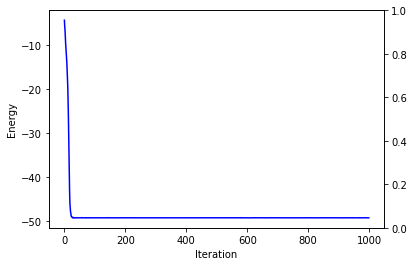

In [ ]:
fig, ax1 = plt.subplots()
ax1.plot(iters, energy, color='blue', label='Energy')
ax1.set_ylabel('Energy')
ax1.set_xlabel('Iteration')
ax2 = ax1.twinx() 
ax2.plot(iters, np.array(sf), color='green', label='Structure Factor')
ax2.set_ylabel('Structure Factor')
ax1.legend(loc=2)
ax2.legend(loc=1)
plt.show()